In [72]:
import torch
import torchvision
from torchvision import datasets,models,transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import copy 
import os
import pdb
from PIL import Image
import scipy.misc as sc
from skimage import measure
from collections import Counter
%matplotlib inline 
plt.ion()

In [30]:
# Transforms

data_transforms = {
    'train':transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.29,0.224,0.225])
    ]),
}

#data_dir = '/home/htic/balamurali/images/class_10'
data_dir = '/media/htic/New Volume/endovis/Processed/Images/new'
dsets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}
dset_loaders = {x :torch.utils.data.DataLoader(dsets[x],batch_size=4,shuffle=True,num_workers=4) for x in ['train','val']}

dset_sizes = {x:len(dsets[x]) for x in ['train','val']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()


In [31]:
# Available classes
print(dsets['train'].classes)

['label0', 'label1']


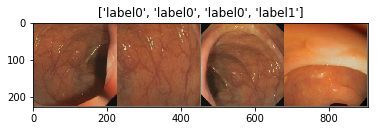

In [32]:
#Image visualization
def imshow(inp,title=None):
    inp  = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std  = np.array([0.229,0.224,0.225])
    inp  = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs,classes = next(iter(dset_loaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out,title=[dset_classes[x] for x in classes])

In [33]:
model_ft = models.alexnet(pretrained=False)
#Reading weights from pretrained model
model_ft.load_state_dict(torch.load('/home/htic/balamurali/models/alexnet-owt-4df8aa71.pth'))
model_new_list = list(model_ft.features)[:-1]
model_feature_global = nn.Sequential(*model_new_list)
# for param in model_feature_global.parameters():
#     param.requires_grad = False

In [34]:
#Models
class Net(nn.Module):
    def __init__(self):
        # This i have to check
        super(Net,self).__init__()
        #Reading weights from pretrained model
        self.model_features = model_feature_global
        self.conv6 = nn.Conv2d(in_channels=256,out_channels=1024,kernel_size=3,stride=1,padding=1)
        self.avg1   = nn.AvgPool2d(kernel_size=13,stride=13,padding=0)
        self.fc1 = nn.Linear(1024,2)
        
    def forward(self,x):
        x = self.model_features(x)
        x = self.conv6(x)
        conv_1024 = x
        x = self.avg1(x)
        x = x.view(-1,1024)
        x = self.fc1(x)
        x = nn.functional.softmax(x)
        return x,conv_1024
        

In [35]:
net = Net()
# print (net)
# This is to verify the random input of dimension 224 goes forward
input = Variable(torch.randn(1, 3, 224, 224))
out,_ = net(input)
print (net)
print(out)

Net (
  (model_features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
  )
  (conv6): Conv2d(256, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avg1): AvgPool2d (
  )
  (fc1): Linear (1024 -> 2)
)
Variable containing:
 0.5180  0.4820
[torch.FloatTensor of size 1x2]



In [36]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs,_ = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

######################################################################
# Learning rate scheduler
# ^^^^^^^^^^^^^^^^^^^^^^^
# Let's create our learning rate scheduler. We will exponentially
# decrease the learning rate once every few epochs.

def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer


######################################################################
# Visualizing the model predictions
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Generic function to display predictions for a few images
#

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs,_ = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.1550 Acc: 0.6562
val Loss: 0.1388 Acc: 0.7282

Epoch 1/24
----------
train Loss: 0.1408 Acc: 0.7316
val Loss: 0.1270 Acc: 0.8043

Epoch 2/24
----------
train Loss: 0.1314 Acc: 0.7814
val Loss: 0.1202 Acc: 0.8347

Epoch 3/24
----------
train Loss: 0.1318 Acc: 0.7733
val Loss: 0.1160 Acc: 0.8509

Epoch 4/24
----------
train Loss: 0.1248 Acc: 0.8064
val Loss: 0.1165 Acc: 0.8398

Epoch 5/24
----------
train Loss: 0.1211 Acc: 0.8196
val Loss: 0.1096 Acc: 0.8793

Epoch 6/24
----------
train Loss: 0.1205 Acc: 0.8210
val Loss: 0.1160 Acc: 0.8458

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.1090 Acc: 0.8758
val Loss: 0.1069 Acc: 0.8803

Epoch 8/24
----------
train Loss: 0.1085 Acc: 0.8775
val Loss: 0.1058 Acc: 0.8803

Epoch 9/24
----------
train Loss: 0.1067 Acc: 0.8836
val Loss: 0.1034 Acc: 0.9037

Epoch 10/24
----------
train Loss: 0.1070 Acc: 0.8802
val Loss: 0.1065 Acc: 0.8783

Epoch 11/24
----------
train Loss: 0.1060 Acc: 

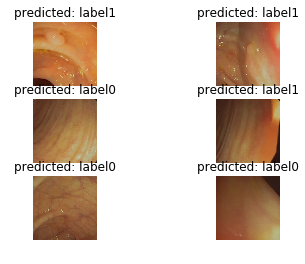

In [37]:
if use_gpu:
    net = net.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(net.parameters(),lr=0.01,momentum=0.9)

net = train_model(net,criterion,optimizer_conv,exp_lr_scheduler,num_epochs=25)
visualize_model(net)
plt.ioff()
plt.show()

In [146]:
imsize = 224
loader = transforms.Compose([transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.29,0.224,0.225])])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image.cuda(), requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image#assumes that you're using GPU
# path = '/media/htic/New Volume/endovis/Processed_224_scaled/Images/15_340.bmp'
# imshow_path(path)
# print (net)
classes = dsets['train'].classes
#print (classes)
file_name = '6_254.jpg'
img_path = '/media/htic/New Volume/endovis/Processed/Images/new/val/label1/%s'%(file_name)
image = image_loader(img_path)
scores,res = net(image)
#print (scores.data)
_, preds = torch.max(scores.data, 1)
preds = preds.cpu()
res = res.cpu()
print(classes[preds.numpy()])
class_no  = preds.numpy()
conv_1024 = res.data.numpy()
print (conv_1024.shape)

label1
(1, 1024, 13, 13)


/home/htic/.local/lib/python3.5/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


(13, 13)
(224, 224, 3)


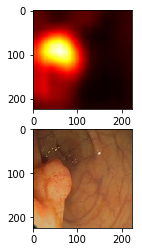

In [147]:
#for param in net.parameters():
imsize = 224
loader = transforms.Compose([transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()])
image = Image.open(img_path)
image = loader(image).numpy()
# print (image.shape)
res1 = np.zeros([224,224,3])
for i in range(3):
    res1[:,:,i] = image[i,:,:]


#print(net.parameters())
layer_no = 2
total = 14
# layer_1024 = 12
for each in net.parameters():
    if total == layer_no:
        numpy_data = each.data.cpu().numpy()
#     if total == layer_1024:
#         numpy_planes = each.data.numpy()
    total -= 1
#     print (each.data.size())
    
# print (numpy_data.shape)
weight = numpy_data[class_no,:].squeeze()
conv_1024_13_13 = conv_1024.squeeze()
# print (conv_1024_13_13.shape)
for i in range(1024):
    conv_1024_13_13[i,:,:] = conv_1024_13_13[i,:,:] * weight[i]
res = np.sum(conv_1024_13_13,axis=0)
res_scaled = sc.imresize(res,[224,224],'bilinear')
print (res.shape)
print (res1.shape)
plt.subplot(2,1,1)
plt.imshow(res_scaled,cmap='hot')
plt.subplot(2,1,2)
plt.imshow(res1)

In [40]:
for each in net.parameters():
    print(each.data.size())

torch.Size([64, 3, 11, 11])
torch.Size([64])
torch.Size([192, 64, 5, 5])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([1024, 256, 3, 3])
torch.Size([1024])
torch.Size([2, 1024])
torch.Size([2])


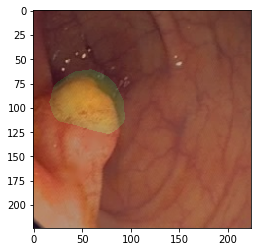

In [153]:
cam = res_scaled
cam_max = np.max(res_scaled)
thresh = (20/100)*cam_max 
res_segment_bool = res_scaled > thresh
cam = cam * res_segment_bool
labels = measure.label(cam)
high = cam > 150
cam = cam * high
plt.figure()
plt.imshow(res1)
plt.imshow(cam,alpha=0.2)
plt.show()

# plt.subplot(1,1,2)
# plt.imshow(labels,cmap='hot')
# print (np.unique(labels))
# labels_1d = labels.ravel()
# label_count = Counter(labels_1d)
# max_label = label_count.most_common(2)
# print (max_label)
# seg_map = (labels == max_label[1][0])
# plt.subplot(3,1,3)
# print (seg_map)
# plt.imshow(seg_map,cmap='hot')

In [1]:
x = [1,2,3,4,1,1,1]
y = Counter(x)
print (y.most_common(1))

NameError: name 'Counter' is not defined